In [ ]:
# Cell 1 — Mount Drive and create folder structure
from google.colab import drive
import os, sys, time
drive.mount('/content/drive', force_remount=True)

BASE = "/content/drive/MyDrive/SignLang_Transfer_Project"
SUBFOLDERS = [
    f"{BASE}/data/ISL",
    f"{BASE}/data/Bengali",
    f"{BASE}/data/Assamese",
    f"{BASE}/models/pretrained",
    f"{BASE}/models/baseline",
    f"{BASE}/models/finetuned",
    f"{BASE}/results/curves",
    f"{BASE}/results/confusion_matrices",
    f"{BASE}/results/embeddings",
    f"{BASE}/results/logs",
    f"{BASE}/scripts"
]
for p in SUBFOLDERS:
    os.makedirs(p, exist_ok=True)

print("Base dir:", BASE)
print("Folders created/verified.")


Mounted at /content/drive
Base dir: /content/drive/MyDrive/SignLang_Transfer_Project
Folders created/verified.


In [ ]:
# Cell 2 — Imports & configuration
import os, time, datetime, json, csv
import numpy as np
import torch, random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import pandas as pd

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Paths to datasets — EDIT HERE only if your files have different names
DATA_PATHS = {
    "ISL": f"{BASE}/data/ISL/isl_prepared.npz",
    "Bengali": f"{BASE}/data/Bengali/bengali_prepared.npz",
    "Assamese": f"{BASE}/data/Assamese/assamese_prepared.npz"
}

# Where to save outputs
MODELS_DIR = f"{BASE}/models"
RESULTS_DIR = f"{BASE}/results"
SCRIPTS_DIR = f"{BASE}/scripts"

# Experiment hyperparams (change if needed)
SEED = 42
BATCH_SIZE = 64
EMB_DIM = 256
HIDDEN1 = 512
EPOCHS_BASE = 20    # baseline training epochs
EPOCHS_FROZEN = 20  # we will use 20 (phase1 frozen)
EPOCHS_FINETUNE = 10
LR_BASE = 1e-3
LR_FINETUNE = 5e-4

# Ensure reproducibility helper
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

print("Paths:")
for k,v in DATA_PATHS.items():
    print(f" - {k}: {v}")


Device: cpu
Paths:
 - ISL: /content/drive/MyDrive/SignLang_Transfer_Project/data/ISL/isl_prepared.npz
 - Bengali: /content/drive/MyDrive/SignLang_Transfer_Project/data/Bengali/bengali_prepared.npz
 - Assamese: /content/drive/MyDrive/SignLang_Transfer_Project/data/Assamese/assamese_prepared.npz


In [ ]:
# Cell 3 — Helpers: loaders, saving, plotting, CSV logging
import pathlib
def make_loader(X, y, batch=BATCH_SIZE, shuffle=True):
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    return DataLoader(TensorDataset(X, y), batch_size=batch, shuffle=shuffle)

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def timestamp():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

def save_model(state_dict, path):
    torch.save(state_dict, path)

def save_plot(fig, path):
    fig.savefig(path, bbox_inches='tight', dpi=200)
    plt.close(fig)

# Logging CSV results per run
def save_metrics_csv(log_rows, path):
    # log_rows: list of dicts per epoch
    keys = log_rows[0].keys()
    with open(path, 'w', newline='') as f:
        writer = csv.DictWriter(f, keys)
        writer.writeheader()
        writer.writerows(log_rows)

# Combined summary append
SUMMARY_CSV = f"{RESULTS_DIR}/summary.csv"
def append_summary_row(row):
    # row is dict matching header; append or create file
    header = ["timestamp","experiment","train_acc","val_acc","test_acc","epochs","seed","model_path","notes","time_s"]
    file_exists = os.path.exists(SUMMARY_CSV)
    with open(SUMMARY_CSV, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=header)
        if not file_exists:
            writer.writeheader()
        writer.writerow({k: row.get(k,"") for k in header})

def plot_accuracy_curves(train_accs, val_accs, title, savepath):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(train_accs, label="Train Acc", linewidth=2)
    ax.plot(val_accs, label="Val Acc", linewidth=2)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()
    save_plot(fig, savepath)

def plot_conf_matrix(y_true, y_pred, labels, title, savepath):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    save_plot(fig, savepath)


In [ ]:
# Cell 4 — Model definitions (use the stable shape: input -> 512 -> 256 -> classifier)
class Encoder(nn.Module):
    def __init__(self, input_dim, emb=EMB_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, HIDDEN1),
            nn.ReLU(),
            nn.Linear(HIDDEN1, emb),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

class Net(nn.Module):
    def __init__(self, input_dim, emb=EMB_DIM, n_classes=10):
        super().__init__()
        self.encoder = Encoder(input_dim, emb)
        self.fc = nn.Linear(emb, n_classes)
    def forward(self, x):
        return self.fc(self.encoder(x))


In [ ]:
# Cell 5 — Training and evaluation utilities
def evaluate_model(model, loader, device=DEVICE):
    model.eval()
    total, correct = 0, 0
    preds_all, labels_all = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = out.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            preds_all.append(preds.cpu().numpy())
            labels_all.append(yb.cpu().numpy())
    acc = correct / total if total>0 else 0.0
    if preds_all:
        preds_all = np.concatenate(preds_all)
        labels_all = np.concatenate(labels_all)
    else:
        preds_all = np.array([])
        labels_all = np.array([])
    return acc, preds_all, labels_all

def train_baseline(model, train_loader, val_loader, epochs=EPOCHS_BASE, lr=LR_BASE, save_prefix="baseline"):
    model = model.to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_accs, val_accs = [], []
    logs = []
    t0 = time.time()
    for ep in range(epochs):
        model.train()
        total, correct = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()
            preds = out.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
        train_acc = correct/total
        val_acc, _, _ = evaluate_model(model, val_loader)
        train_accs.append(train_acc); val_accs.append(val_acc)
        logs.append({"epoch": ep+1, "train_acc": train_acc, "val_acc": val_acc})
        # tqdm style print minimal
        print(f"[{save_prefix}] Epoch {ep+1}/{epochs} | Train: {train_acc:.4f}, Val: {val_acc:.4f}")
    elapsed = time.time()-t0
    return model, train_accs, val_accs, logs, elapsed

def finetune_transfer(model, train_loader, val_loader, pretrained_state=None, freeze_encoder_first=True,
                      epochs_frozen=EPOCHS_FROZEN, epochs_ft=EPOCHS_FINETUNE, lr_frozen=LR_BASE, lr_ft=LR_FINETUNE,
                      save_prefix="transfer"):
    # load pretrained encoder weights where compatible
    if pretrained_state is not None:
        model_state = model.state_dict()
        compatible = {}
        for k,v in pretrained_state.items():
            if k in model_state and v.shape == model_state[k].shape:
                compatible[k] = v
        model_state.update(compatible)
        model.load_state_dict(model_state)
        print(f"✅ Loaded {len(compatible)} compatible layers from pretrained state for {save_prefix}.")
    model = model.to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    logs = []
    train_accs, val_accs = [], []
    t0 = time.time()
    # Phase 1: freeze encoder
    if freeze_encoder_first:
        for p in model.encoder.parameters():
            p.requires_grad = False
        opt = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_frozen)
        for ep in range(epochs_frozen):
            model.train()
            total, correct = 0, 0
            for xb, yb in train_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                opt.zero_grad()
                out = model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                opt.step()
                preds = out.argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
            train_acc = correct/total
            val_acc, _, _ = evaluate_model(model, val_loader)
            train_accs.append(train_acc); val_accs.append(val_acc)
            logs.append({"phase":"frozen","epoch":ep+1,"train_acc":train_acc,"val_acc":val_acc})
            print(f"[{save_prefix} Phase Frozen] Epoch {ep+1}/{epochs_frozen} | Train: {train_acc:.4f}, Val: {val_acc:.4f}")
    # Phase 2: unfreeze and fine-tune all
    for p in model.encoder.parameters():
        p.requires_grad = True
    opt = optim.Adam(model.parameters(), lr=lr_ft)
    for ep in range(epochs_ft):
        model.train()
        total, correct = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()
            preds = out.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
        train_acc = correct/total
        val_acc, _, _ = evaluate_model(model, val_loader)
        train_accs.append(train_acc); val_accs.append(val_acc)
        logs.append({"phase":"finetune","epoch":ep+1,"train_acc":train_acc,"val_acc":val_acc})
        print(f"[{save_prefix} Fine-tune] Epoch {ep+1}/{epochs_ft} | Train: {train_acc:.4f}, Val: {val_acc:.4f}")
    elapsed = time.time()-t0
    return model, train_accs, val_accs, logs, elapsed


In [ ]:
# Cell 6 — Load datasets
datasets = {}
for name, path in DATA_PATHS.items():
    if not os.path.exists(path):
        print(f"WARNING: dataset not found: {path}")
        datasets[name] = None
    else:
        data = np.load(path)
        # expects arrays: X_train, y_train, X_val, y_val, X_test, y_test
        X_train, y_train = data["X_train"], data["y_train"]
        X_val, y_val = data["X_val"], data["y_val"]
        X_test, y_test = data["X_test"], data["y_test"]
        print(f"{name} shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
        datasets[name] = {
            "X_train": X_train, "y_train": y_train,
            "X_val": X_val, "y_val": y_val,
            "X_test": X_test, "y_test": y_test
        }

ISL shapes -> Train: (40687, 126), Val: (5086, 126), Test: (5086, 126)
Bengali shapes -> Train: (8469, 126), Val: (1059, 126), Test: (1059, 126)
Assamese shapes -> Train: (1593, 126), Val: (199, 126), Test: (200, 126)


In [ ]:
# Cell 7 — ISL pretraining (train from scratch on ISL dataset)
set_seed()
if datasets.get("ISL") is None:
    raise RuntimeError("ISL dataset not loaded. Place file at: " + DATA_PATHS["ISL"])

# Build loaders
isl = datasets["ISL"]
in_dim = isl["X_train"].shape[1]
n_classes_isl = len(np.unique(isl["y_train"]))
print("ISL input dim:", in_dim, "classes:", n_classes_isl)

train_loader = make_loader(isl["X_train"], isl["y_train"], batch=BATCH_SIZE, shuffle=True)
val_loader   = make_loader(isl["X_val"], isl["y_val"], batch=BATCH_SIZE, shuffle=False)
test_loader  = make_loader(isl["X_test"], isl["y_test"], batch=BATCH_SIZE, shuffle=True)

# Model
isl_model = Net(in_dim, EMB_DIM, n_classes_isl)
print("Training ISL baseline...")
isl_model, train_accs_isl, val_accs_isl, logs_isl, t_isl = train_baseline(
    isl_model, train_loader, val_loader, epochs=EPOCHS_BASE, lr=LR_BASE, save_prefix="ISL_Baseline"
)

# Evaluate test
test_acc_isl, preds_isl, labels_isl = evaluate_model(isl_model, test_loader)
print(f"ISL Test Accuracy: {test_acc_isl:.4f} (time {t_isl:.1f}s)")

# Save model + logs + plot
ts = timestamp()
model_path = f"{MODELS_DIR}/pretrained/isl_pretrained_{ts}.pth"
save_model(isl_model.state_dict(), model_path)
print("Saved ISL pretrained model to:", model_path)

# Save curve PNG & logs CSV
curve_path = f"{RESULTS_DIR}/curves/isl_pretrain_{ts}.png"
plot_accuracy_curves(train_accs_isl, val_accs_isl, "ISL Baseline Training", curve_path)
log_path = f"{RESULTS_DIR}/logs/isl_pretrain_{ts}.csv"
save_metrics_csv([{"epoch":i+1,"train_acc":a,"val_acc":b} for i,(a,b) in enumerate(zip(train_accs_isl,val_accs_isl))], log_path)

append_summary_row({
    "timestamp": ts, "experiment":"ISL_Baseline",
    "train_acc": train_accs_isl[-1], "val_acc": val_accs_isl[-1],
    "test_acc": test_acc_isl, "epochs":EPOCHS_BASE, "seed":SEED,
    "model_path": model_path, "notes":"ISL pretrained", "time_s": round(t_isl,1)
})

# Keep pretrained state in memory for quick loads
pretrained_isl_state = isl_model.state_dict()


ISL input dim: 126 classes: 26
Training ISL baseline...
[ISL_Baseline] Epoch 1/20 | Train: 0.9138, Val: 0.8928
[ISL_Baseline] Epoch 2/20 | Train: 0.9614, Val: 0.8978
[ISL_Baseline] Epoch 3/20 | Train: 0.9691, Val: 0.9335
[ISL_Baseline] Epoch 4/20 | Train: 0.9727, Val: 0.9564
[ISL_Baseline] Epoch 5/20 | Train: 0.9772, Val: 0.9888
[ISL_Baseline] Epoch 6/20 | Train: 0.9795, Val: 0.9715
[ISL_Baseline] Epoch 7/20 | Train: 0.9824, Val: 0.9479
[ISL_Baseline] Epoch 8/20 | Train: 0.9833, Val: 0.9369
[ISL_Baseline] Epoch 9/20 | Train: 0.9845, Val: 0.9416
[ISL_Baseline] Epoch 10/20 | Train: 0.9848, Val: 0.9233
[ISL_Baseline] Epoch 11/20 | Train: 0.9871, Val: 0.9550
[ISL_Baseline] Epoch 12/20 | Train: 0.9855, Val: 0.9471
[ISL_Baseline] Epoch 13/20 | Train: 0.9861, Val: 0.9801
[ISL_Baseline] Epoch 14/20 | Train: 0.9880, Val: 0.9597
[ISL_Baseline] Epoch 15/20 | Train: 0.9882, Val: 0.9841
[ISL_Baseline] Epoch 16/20 | Train: 0.9886, Val: 0.9882
[ISL_Baseline] Epoch 17/20 | Train: 0.9885, Val: 0.8958
[

In [ ]:
# Cell 8 — Bengali baseline + ISL->Bengali transfer
set_seed()
if datasets.get("Bengali") is None:
    raise RuntimeError("Bengali dataset not loaded. Path: " + DATA_PATHS["Bengali"])

beng = datasets["Bengali"]
in_dim_b = beng["X_train"].shape[1]
n_classes_b = len(np.unique(beng["y_train"]))
print("Bengali input dim:", in_dim_b, "classes:", n_classes_b)

train_loader = make_loader(beng["X_train"], beng["y_train"], batch=BATCH_SIZE)
val_loader   = make_loader(beng["X_val"], beng["y_val"], batch=BATCH_SIZE, shuffle=False)
test_loader  = make_loader(beng["X_test"], beng["y_test"], batch=BATCH_SIZE, shuffle=True)

# 1) Bengali Baseline
beng_baseline = Net(in_dim_b, EMB_DIM, n_classes_b)
beng_baseline, train_accs_b_base, val_accs_b_base, logs_b_base, t_b_base = train_baseline(
    beng_baseline, train_loader, val_loader, epochs=EPOCHS_BASE, lr=LR_BASE, save_prefix="Bengali_Baseline"
)
test_acc_b_base, preds_b_base, labels_b_base = evaluate_model(beng_baseline, test_loader)
print(f"Bengali Baseline Test Acc: {test_acc_b_base:.4f}")

# Save baseline model + plots
ts = timestamp()
model_b_base_path = f"{MODELS_DIR}/baseline/bengali_baseline_{ts}.pth"
save_model(beng_baseline.state_dict(), model_b_base_path)
plot_accuracy_curves(train_accs_b_base, val_accs_b_base, "Bengali Baseline", f"{RESULTS_DIR}/curves/bengali_baseline_{ts}.png")
save_metrics_csv([{"epoch":i+1,"train_acc":a,"val_acc":b} for i,(a,b) in enumerate(zip(train_accs_b_base,val_accs_b_base))], f"{RESULTS_DIR}/logs/bengali_baseline_{ts}.csv")
append_summary_row({"timestamp":ts,"experiment":"Bengali_Baseline","train_acc":train_accs_b_base[-1],"val_acc":val_accs_b_base[-1],"test_acc":test_acc_b_base,"epochs":EPOCHS_BASE,"seed":SEED,"model_path":model_b_base_path,"notes":"baseline","time_s":round(t_b_base,1)})

# 2) ISL -> Bengali (transfer)
beng_transfer = Net(in_dim_b, EMB_DIM, n_classes_b)
# use pretrained_isl_state from ISL cell
beng_transfer, train_accs_b_tr, val_accs_b_tr, logs_b_tr, t_b_tr = finetune_transfer(
    beng_transfer, train_loader, val_loader, pretrained_state=pretrained_isl_state,
    freeze_encoder_first=True, epochs_frozen=EPOCHS_FROZEN, epochs_ft=EPOCHS_FINETUNE,
    lr_frozen=LR_BASE, lr_ft=LR_FINETUNE, save_prefix="ISL_to_Bengali"
)
test_acc_b_tr, preds_b_tr, labels_b_tr = evaluate_model(beng_transfer, test_loader)
print(f"ISL -> Bengali Test Acc: {test_acc_b_tr:.4f}")

# Save transfer model + plots
ts = timestamp()
model_b_tr_path = f"{MODELS_DIR}/finetuned/isl_to_bengali_{ts}.pth"
save_model(beng_transfer.state_dict(), model_b_tr_path)
# Combined curve: we have train_accs_b_tr & val_accs_b_tr covering both phases
plot_accuracy_curves(train_accs_b_tr, val_accs_b_tr, "ISL → Bengali Fine-tuning", f"{RESULTS_DIR}/curves/isl_to_bengali_{ts}.png")
save_metrics_csv([{"epoch":i+1,"train_acc":a,"val_acc":b} for i,(a,b) in enumerate(zip(train_accs_b_tr,val_accs_b_tr))], f"{RESULTS_DIR}/logs/isl_to_bengali_{ts}.csv")
append_summary_row({"timestamp":ts,"experiment":"ISL_to_Bengali","train_acc":train_accs_b_tr[-1],"val_acc":val_accs_b_tr[-1],"test_acc":test_acc_b_tr,"epochs":EPOCHS_FROZEN+EPOCHS_FINETUNE,"seed":SEED,"model_path":model_b_tr_path,"notes":"transfer from ISL","time_s":round(t_b_tr,1)})

# Confusion matrices for both baseline & transfer
labels_list_b = list(range(n_classes_b))
plot_conf_matrix(labels_b_base, preds_b_base, labels_list_b, "Bengali Baseline Confusion", f"{RESULTS_DIR}/confusion_matrices/bengali_baseline_cm_{ts}.png")
plot_conf_matrix(labels_b_tr, preds_b_tr, labels_list_b, "ISL→Bengali Confusion", f"{RESULTS_DIR}/confusion_matrices/isl_to_bengali_cm_{ts}.png")



Bengali input dim: 126 classes: 38
[Bengali_Baseline] Epoch 1/20 | Train: 0.7024, Val: 0.6346
[Bengali_Baseline] Epoch 2/20 | Train: 0.8380, Val: 0.5968
[Bengali_Baseline] Epoch 3/20 | Train: 0.8630, Val: 0.6166
[Bengali_Baseline] Epoch 4/20 | Train: 0.8804, Val: 0.5949
[Bengali_Baseline] Epoch 5/20 | Train: 0.8845, Val: 0.7082
[Bengali_Baseline] Epoch 6/20 | Train: 0.8964, Val: 0.6978
[Bengali_Baseline] Epoch 7/20 | Train: 0.9023, Val: 0.7620
[Bengali_Baseline] Epoch 8/20 | Train: 0.9068, Val: 0.6648
[Bengali_Baseline] Epoch 9/20 | Train: 0.9092, Val: 0.7384
[Bengali_Baseline] Epoch 10/20 | Train: 0.9157, Val: 0.6657
[Bengali_Baseline] Epoch 11/20 | Train: 0.9216, Val: 0.7913
[Bengali_Baseline] Epoch 12/20 | Train: 0.9230, Val: 0.7054
[Bengali_Baseline] Epoch 13/20 | Train: 0.9310, Val: 0.7913
[Bengali_Baseline] Epoch 14/20 | Train: 0.9310, Val: 0.7545
[Bengali_Baseline] Epoch 15/20 | Train: 0.9358, Val: 0.8093
[Bengali_Baseline] Epoch 16/20 | Train: 0.9408, Val: 0.7082
[Bengali_Basel

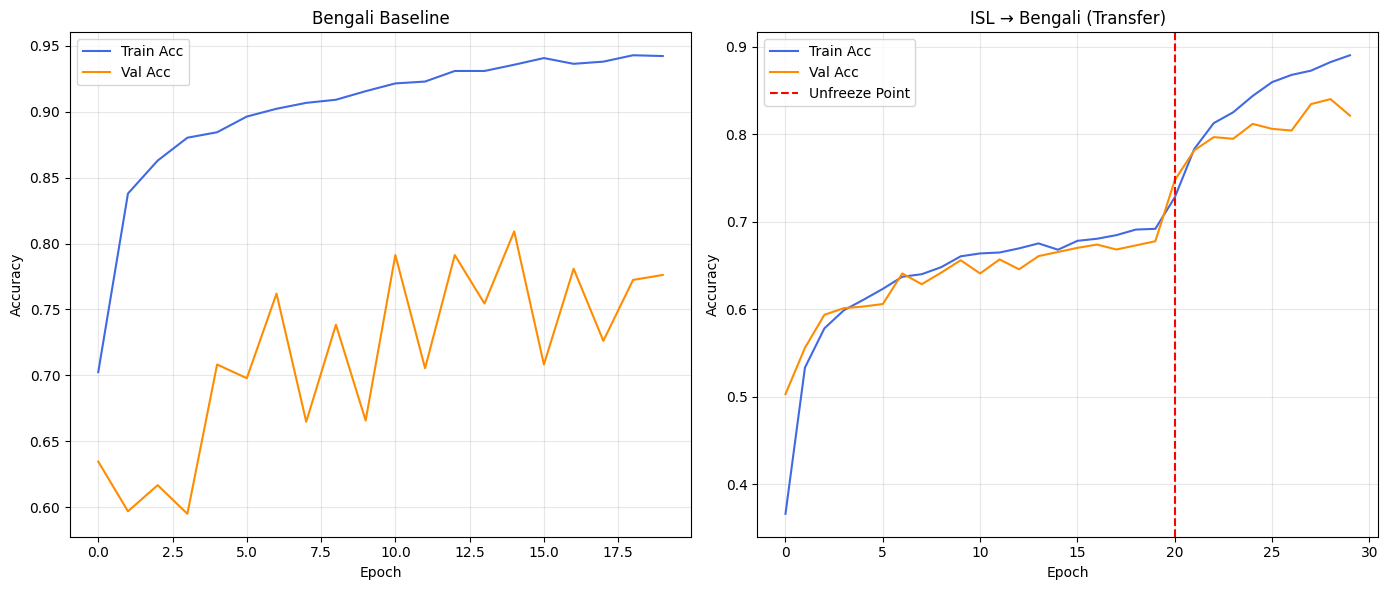

✅ Saved plot: /content/drive/MyDrive/SignLang_Transfer_Project/results/plots/bengali_baseline_vs_transfer.png


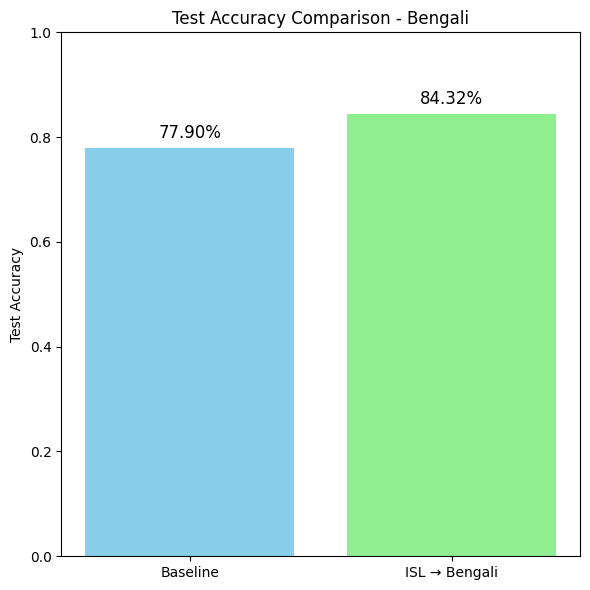

✅ Saved bar chart: /content/drive/MyDrive/SignLang_Transfer_Project/results/plots/bengali_test_accuracy_comparison.png
✅ Logged metrics saved at: /content/drive/MyDrive/SignLang_Transfer_Project/results/logs/bengali_results.json


In [ ]:
# Cell 8.a — Bengali Baseline vs ISL→Bengali Transfer Visualization + Logging
import json
import matplotlib.pyplot as plt
import os

# ======================
# ✅ CONFIG
# ======================
RESULTS_DIR = "/content/drive/MyDrive/SignLang_Transfer_Project/results"
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
LOGS_DIR = os.path.join(RESULTS_DIR, "logs")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# Map actual variable names
baseline_train_acc = train_accs_b_base
baseline_val_acc   = val_accs_b_base
transfer_train_acc = train_accs_b_tr
transfer_val_acc   = val_accs_b_tr
bengali_baseline_test_acc = test_acc_b_base
isl_to_bengali_test_acc   = test_acc_b_tr

# ======================
# ✅ 1️⃣ Accuracy Curves
# ======================
plt.figure(figsize=(14,6))

# Left subplot: Baseline
plt.subplot(1,2,1)
plt.plot(baseline_train_acc, label='Train Acc', color='royalblue')
plt.plot(baseline_val_acc, label='Val Acc', color='darkorange')
plt.title("Bengali Baseline")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Right subplot: Transfer
plt.subplot(1,2,2)
plt.plot(transfer_train_acc, label='Train Acc', color='royalblue')
plt.plot(transfer_val_acc, label='Val Acc', color='darkorange')
plt.axvline(x=len(transfer_train_acc)-10, color='red', linestyle='--', label='Unfreeze Point')
plt.title("ISL → Bengali (Transfer)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the combined plot
plot_path = os.path.join(PLOTS_DIR, "bengali_baseline_vs_transfer.png")
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"✅ Saved plot: {plot_path}")

# ======================
# ✅ 2️⃣ Bar Chart (Test Acc)
# ======================
plt.figure(figsize=(6,6))
labels = ["Baseline", "ISL → Bengali"]
values = [bengali_baseline_test_acc, isl_to_bengali_test_acc]
plt.bar(labels, values, color=["skyblue", "lightgreen"])
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison - Bengali")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', fontsize=12)
bar_path = os.path.join(PLOTS_DIR, "bengali_test_accuracy_comparison.png")
plt.tight_layout()
plt.savefig(bar_path, dpi=300)
plt.show()
print(f"✅ Saved bar chart: {bar_path}")

# ======================
# ✅ 3️⃣ Save Log File
# ======================
results_data = {
    "baseline_test_acc": float(bengali_baseline_test_acc),
    "transfer_test_acc": float(isl_to_bengali_test_acc),
    "baseline_train_acc": [float(x) for x in baseline_train_acc],
    "baseline_val_acc": [float(x) for x in baseline_val_acc],
    "transfer_train_acc": [float(x) for x in transfer_train_acc],
    "transfer_val_acc": [float(x) for x in transfer_val_acc]
}
json_path = os.path.join(LOGS_DIR, "bengali_results.json")
with open(json_path, "w") as f:
    json.dump(results_data, f, indent=4)
print(f"✅ Logged metrics saved at: {json_path}")


In [ ]:
# Cell 9 — Assamese baseline + ISL->Assamese transfer
set_seed()
if datasets.get("Assamese") is None:
    raise RuntimeError("Assamese dataset not loaded. Path: " + DATA_PATHS["Assamese"])

ass = datasets["Assamese"]
in_dim_a = ass["X_train"].shape[1]
n_classes_a = len(np.unique(ass["y_train"]))
print("Assamese input dim:", in_dim_a, "classes:", n_classes_a)

train_loader = make_loader(ass["X_train"], ass["y_train"], batch=BATCH_SIZE)
val_loader   = make_loader(ass["X_val"], ass["y_val"], batch=BATCH_SIZE, shuffle=False)
test_loader  = make_loader(ass["X_test"], ass["y_test"], batch=BATCH_SIZE, shuffle=True)

# 1) Assamese Baseline
ass_baseline = Net(in_dim_a, EMB_DIM, n_classes_a)
ass_baseline, train_accs_a_base, val_accs_a_base, logs_a_base, t_a_base = train_baseline(
    ass_baseline, train_loader, val_loader, epochs=EPOCHS_BASE, lr=LR_BASE, save_prefix="Assamese_Baseline"
)
test_acc_a_base, preds_a_base, labels_a_base = evaluate_model(ass_baseline, test_loader)
print(f"Assamese Baseline Test Acc: {test_acc_a_base:.4f}")

# Save baseline model + plots
ts = timestamp()
model_a_base_path = f"{MODELS_DIR}/baseline/assamese_baseline_{ts}.pth"
save_model(ass_baseline.state_dict(), model_a_base_path)
plot_accuracy_curves(train_accs_a_base, val_accs_a_base, "Assamese Baseline", f"{RESULTS_DIR}/curves/assamese_baseline_{ts}.png")
save_metrics_csv([{"epoch":i+1,"train_acc":a,"val_acc":b} for i,(a,b) in enumerate(zip(train_accs_a_base,val_accs_a_base))], f"{RESULTS_DIR}/logs/assamese_baseline_{ts}.csv")
append_summary_row({"timestamp":ts,"experiment":"Assamese_Baseline","train_acc":train_accs_a_base[-1],"val_acc":val_accs_a_base[-1],"test_acc":test_acc_a_base,"epochs":EPOCHS_BASE,"seed":SEED,"model_path":model_a_base_path,"notes":"baseline","time_s":round(t_a_base,1)})

# 2) ISL -> Assamese (transfer)
ass_transfer = Net(in_dim_a, EMB_DIM, n_classes_a)
ass_transfer, train_accs_a_tr, val_accs_a_tr, logs_a_tr, t_a_tr = finetune_transfer(
    ass_transfer, train_loader, val_loader, pretrained_state=pretrained_isl_state,
    freeze_encoder_first=True, epochs_frozen=EPOCHS_FROZEN, epochs_ft=EPOCHS_FINETUNE,
    lr_frozen=LR_BASE, lr_ft=LR_FINETUNE, save_prefix="ISL_to_Assamese"
)
test_acc_a_tr, preds_a_tr, labels_a_tr = evaluate_model(ass_transfer, test_loader)
print(f"ISL -> Assamese Test Acc: {test_acc_a_tr:.4f}")

# Save transfer model + plots
ts = timestamp()
model_a_tr_path = f"{MODELS_DIR}/finetuned/isl_to_assamese_{ts}.pth"
save_model(ass_transfer.state_dict(), model_a_tr_path)
plot_accuracy_curves(train_accs_a_tr, val_accs_a_tr, "ISL → Assamese Fine-tuning", f"{RESULTS_DIR}/curves/isl_to_assamese_{ts}.png")
save_metrics_csv([{"epoch":i+1,"train_acc":a,"val_acc":b} for i,(a,b) in enumerate(zip(train_accs_a_tr,val_accs_a_tr))], f"{RESULTS_DIR}/logs/isl_to_assamese_{ts}.csv")
append_summary_row({"timestamp":ts,"experiment":"ISL_to_Assamese","train_acc":train_accs_a_tr[-1],"val_acc":val_accs_a_tr[-1],"test_acc":test_acc_a_tr,"epochs":EPOCHS_FROZEN+EPOCHS_FINETUNE,"seed":SEED,"model_path":model_a_tr_path,"notes":"transfer from ISL","time_s":round(t_a_tr,1)})

# Confusion matrices
labels_list_a = list(range(n_classes_a))
plot_conf_matrix(labels_a_base, preds_a_base, labels_list_a, "Assamese Baseline Confusion", f"{RESULTS_DIR}/confusion_matrices/assamese_baseline_cm_{ts}.png")
plot_conf_matrix(labels_a_tr, preds_a_tr, labels_list_a, "ISL→Assamese Confusion", f"{RESULTS_DIR}/confusion_matrices/isl_to_assamese_cm_{ts}.png")


Assamese input dim: 126 classes: 9
[Assamese_Baseline] Epoch 1/20 | Train: 0.9134, Val: 0.6030
[Assamese_Baseline] Epoch 2/20 | Train: 0.9931, Val: 1.0000
[Assamese_Baseline] Epoch 3/20 | Train: 0.9950, Val: 1.0000
[Assamese_Baseline] Epoch 4/20 | Train: 0.9969, Val: 0.9950
[Assamese_Baseline] Epoch 5/20 | Train: 0.9937, Val: 1.0000
[Assamese_Baseline] Epoch 6/20 | Train: 0.9975, Val: 1.0000
[Assamese_Baseline] Epoch 7/20 | Train: 0.9969, Val: 1.0000
[Assamese_Baseline] Epoch 8/20 | Train: 0.9987, Val: 0.9950
[Assamese_Baseline] Epoch 9/20 | Train: 0.9987, Val: 1.0000
[Assamese_Baseline] Epoch 10/20 | Train: 0.9987, Val: 1.0000
[Assamese_Baseline] Epoch 11/20 | Train: 1.0000, Val: 1.0000
[Assamese_Baseline] Epoch 12/20 | Train: 1.0000, Val: 1.0000
[Assamese_Baseline] Epoch 13/20 | Train: 0.9994, Val: 1.0000
[Assamese_Baseline] Epoch 14/20 | Train: 1.0000, Val: 1.0000
[Assamese_Baseline] Epoch 15/20 | Train: 0.9994, Val: 1.0000
[Assamese_Baseline] Epoch 16/20 | Train: 1.0000, Val: 1.000

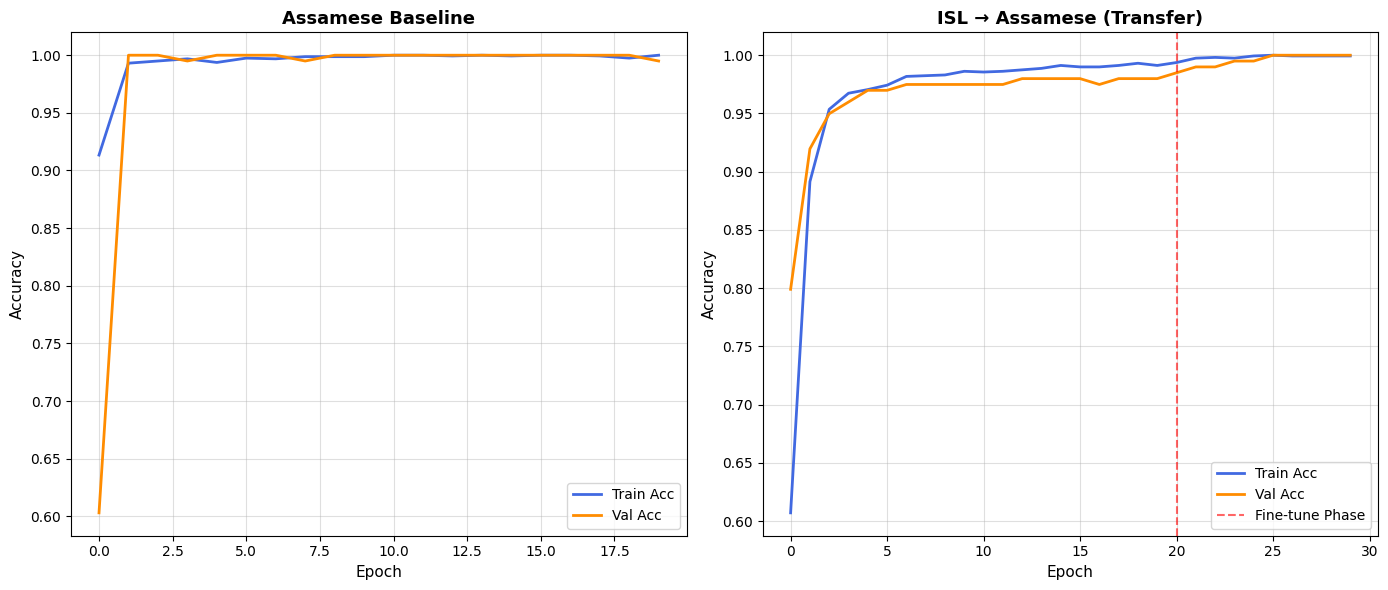

✅ Saved plot: /content/drive/MyDrive/SignLang_Transfer_Project/results/plots/assamese_baseline_vs_transfer_improved.png


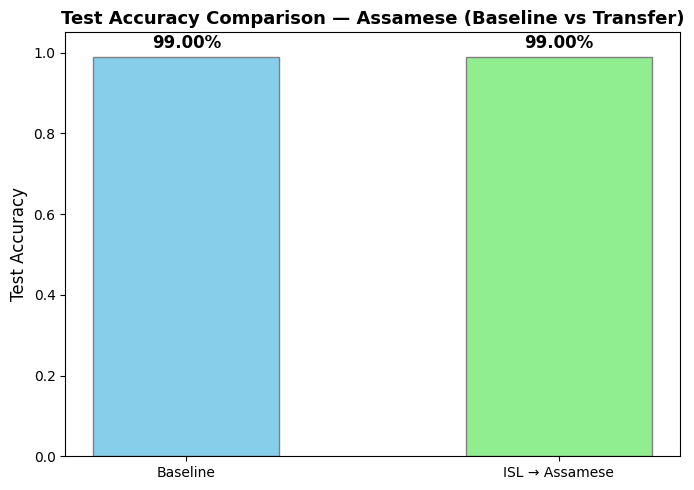

✅ Saved bar chart: /content/drive/MyDrive/SignLang_Transfer_Project/results/plots/assamese_test_accuracy_comparison_improved.png
✅ Logged metrics saved at: /content/drive/MyDrive/SignLang_Transfer_Project/results/logs/assamese_results_improved.json


In [ ]:
# ✅ Cell 9.a — Improved Assamese Visualizations (Baseline vs Transfer)
import json
import matplotlib.pyplot as plt
import os

# ======================
# 📁 CONFIG
# ======================
RESULTS_DIR = "/content/drive/MyDrive/SignLang_Transfer_Project/results"
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
LOGS_DIR = os.path.join(RESULTS_DIR, "logs")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# These should already be defined:
# train_accs_a_base, val_accs_a_base, train_accs_a_tr, val_accs_a_tr
# test_acc_a_base, test_acc_a_tr

# ======================
# 🎯 1️⃣ Accuracy Curves
# ======================
plt.figure(figsize=(14,6))

# ---- Baseline ----
plt.subplot(1,2,1)
plt.plot(train_accs_a_base, label='Train Acc', color='royalblue', linewidth=2)
plt.plot(val_accs_a_base, label='Val Acc', color='darkorange', linewidth=2)
plt.title("Assamese Baseline", fontsize=13, weight='bold')
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)
plt.grid(alpha=0.4)
plt.legend(fontsize=10, loc='lower right')

# ---- Transfer ----
plt.subplot(1,2,2)
plt.plot(train_accs_a_tr, label='Train Acc', color='royalblue', linewidth=2)
plt.plot(val_accs_a_tr, label='Val Acc', color='darkorange', linewidth=2)
plt.axvline(x=len(train_accs_a_tr)-10, color='red', linestyle='--', alpha=0.6, label='Fine-tune Phase')
plt.title("ISL → Assamese (Transfer)", fontsize=13, weight='bold')
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)
plt.grid(alpha=0.4)
plt.legend(fontsize=10, loc='lower right')

plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, "assamese_baseline_vs_transfer_improved.png")
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"✅ Saved plot: {plot_path}")

# ======================
# 🎯 2️⃣ Bar Chart (Test Accuracy)
# ======================
plt.figure(figsize=(7,5))
labels = ["Baseline", "ISL → Assamese"]
values = [test_acc_a_base, test_acc_a_tr]

bars = plt.bar(labels, values, color=["skyblue", "lightgreen"], width=0.5, edgecolor='gray')
plt.ylim(0, 1.05)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("Test Accuracy Comparison — Assamese (Baseline vs Transfer)", fontsize=13, weight='bold')

# Add numeric labels above bars
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v*100:.2f}%", ha='center', fontsize=12, weight='bold')

bar_path = os.path.join(PLOTS_DIR, "assamese_test_accuracy_comparison_improved.png")
plt.tight_layout()
plt.savefig(bar_path, dpi=300)
plt.show()
print(f"✅ Saved bar chart: {bar_path}")

# ======================
# 🎯 3️⃣ Log JSON file
# ======================
results_data = {
    "baseline_test_acc": float(test_acc_a_base),
    "transfer_test_acc": float(test_acc_a_tr),
    "baseline_train_acc": [float(x) for x in train_accs_a_base],
    "baseline_val_acc": [float(x) for x in val_accs_a_base],
    "transfer_train_acc": [float(x) for x in train_accs_a_tr],
    "transfer_val_acc": [float(x) for x in val_accs_a_tr]
}
json_path = os.path.join(LOGS_DIR, "assamese_results_improved.json")
with open(json_path, "w") as f:
    json.dump(results_data, f, indent=4)
print(f"✅ Logged metrics saved at: {json_path}")


In [ ]:
# Cell 10 — Bengali -> Assamese transfer (load bengali pretrained if exists; otherwise use beng_baseline model)
set_seed()

# Attempt to use the previously trained beng_transfer model in memory;
# if not present, try load from model file bengali_baseline or isl_to_bengali if you prefer.
# We'll use beng_baseline encoder weights (works well); alternatively, load a saved path.
beng_encoder_state = None
try:
    beng_encoder_state = beng_transfer.state_dict()
    print("Using in-memory Bengali transfer model weights as source.")
except NameError:
    # try loading baseline Bengali saved model if exists
    print("No in-memory Bengali model found; using Bengali baseline if present.")
    try:
        beng_encoder_state = beng_baseline.state_dict()
    except NameError:
        beng_encoder_state = None

# Build model for Assamese with Bengali encoder preloaded where compatible
b2a_model = Net(in_dim_a, EMB_DIM, n_classes_a)
b2a_model, train_accs_b2a, val_accs_b2a, logs_b2a, t_b2a = finetune_transfer(
    b2a_model, train_loader, val_loader, pretrained_state=beng_encoder_state,
    freeze_encoder_first=True, epochs_frozen=EPOCHS_FROZEN, epochs_ft=EPOCHS_FINETUNE,
    lr_frozen=LR_BASE, lr_ft=LR_FINETUNE, save_prefix="Bengali_to_Assamese"
)
test_acc_b2a, preds_b2a, labels_b2a = evaluate_model(b2a_model, test_loader)
print(f"Bengali → Assamese Test Acc: {test_acc_b2a:.4f}")

# Save model + plots
ts = timestamp()
model_b2a_path = f"{MODELS_DIR}/finetuned/bengali_to_assamese_{ts}.pth"
save_model(b2a_model.state_dict(), model_b2a_path)
plot_accuracy_curves(train_accs_b2a, val_accs_b2a, "Bengali → Assamese Fine-tuning", f"{RESULTS_DIR}/curves/bengali_to_assamese_{ts}.png")
save_metrics_csv([{"epoch":i+1,"train_acc":a,"val_acc":b} for i,(a,b) in enumerate(zip(train_accs_b2a,val_accs_b2a))], f"{RESULTS_DIR}/logs/bengali_to_assamese_{ts}.csv")
append_summary_row({"timestamp":ts,"experiment":"Bengali_to_Assamese","train_acc":train_accs_b2a[-1],"val_acc":val_accs_b2a[-1],"test_acc":test_acc_b2a,"epochs":EPOCHS_FROZEN+EPOCHS_FINETUNE,"seed":SEED,"model_path":model_b2a_path,"notes":"transfer from Bengali","time_s":round(t_b2a,1)})

# Confusion_matrix
plot_conf_matrix(labels_b2a, preds_b2a, labels_list_a, "Bengali→Assamese Confusion", f"{RESULTS_DIR}/confusion_matrices/bengali_to_assamese_cm_{ts}.png")


Using in-memory Bengali transfer model weights as source.
✅ Loaded 14 compatible layers from pretrained state for Bengali_to_Assamese.
[Bengali_to_Assamese Phase Frozen] Epoch 1/20 | Train: 0.5763, Val: 0.7789
[Bengali_to_Assamese Phase Frozen] Epoch 2/20 | Train: 0.8939, Val: 0.9296
[Bengali_to_Assamese Phase Frozen] Epoch 3/20 | Train: 0.9623, Val: 0.9648
[Bengali_to_Assamese Phase Frozen] Epoch 4/20 | Train: 0.9780, Val: 0.9749
[Bengali_to_Assamese Phase Frozen] Epoch 5/20 | Train: 0.9761, Val: 0.9749
[Bengali_to_Assamese Phase Frozen] Epoch 6/20 | Train: 0.9805, Val: 0.9799
[Bengali_to_Assamese Phase Frozen] Epoch 7/20 | Train: 0.9856, Val: 0.9749
[Bengali_to_Assamese Phase Frozen] Epoch 8/20 | Train: 0.9881, Val: 0.9749
[Bengali_to_Assamese Phase Frozen] Epoch 9/20 | Train: 0.9856, Val: 0.9749
[Bengali_to_Assamese Phase Frozen] Epoch 10/20 | Train: 0.9906, Val: 0.9749
[Bengali_to_Assamese Phase Frozen] Epoch 11/20 | Train: 0.9918, Val: 0.9749
[Bengali_to_Assamese Phase Frozen] Epo

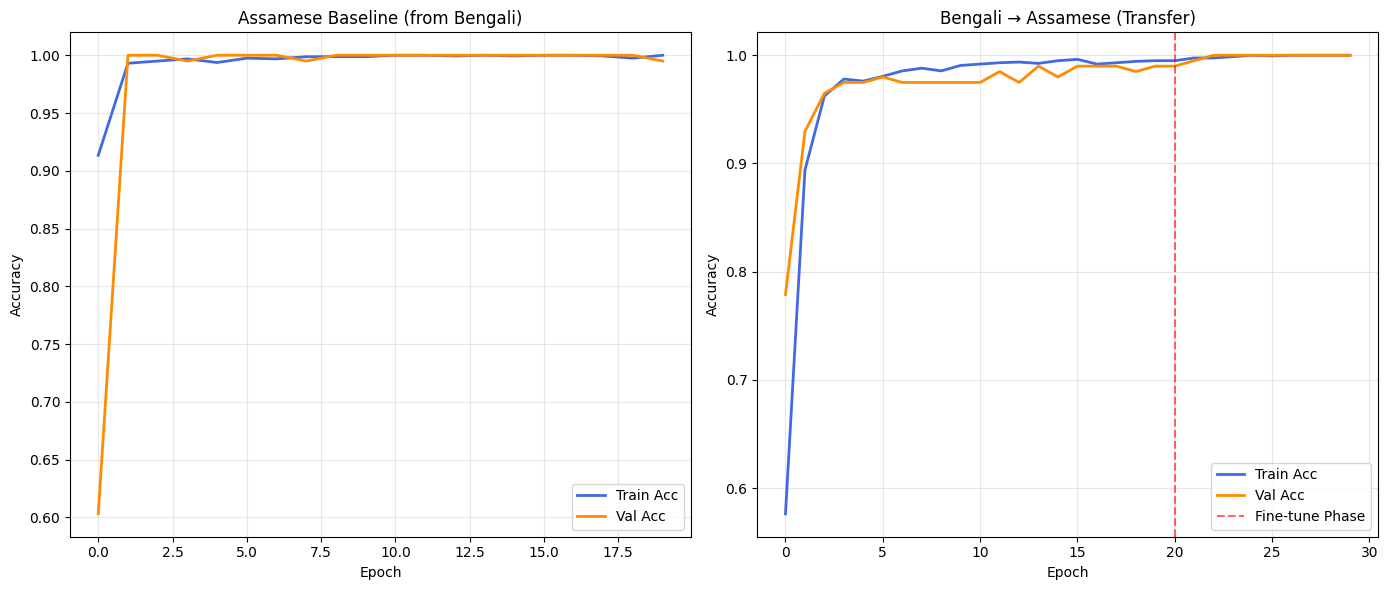

✅ Saved plot: /content/drive/MyDrive/SignLang_Transfer_Project/results/plots/bengali_to_assamese_baseline_vs_transfer.png


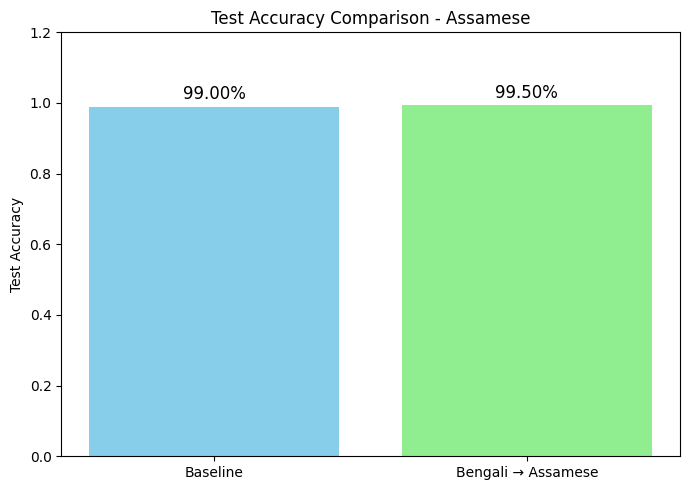

✅ Saved bar chart: /content/drive/MyDrive/SignLang_Transfer_Project/results/plots/bengali_to_assamese_test_accuracy_comparison.png
✅ Logged metrics saved at: /content/drive/MyDrive/SignLang_Transfer_Project/results/logs/bengali_to_assamese_results.json


In [ ]:
# ======================
# ✅ CONFIG
# ======================
import matplotlib.pyplot as plt
import os, json

RESULTS_DIR = "/content/drive/MyDrive/SignLang_Transfer_Project/results"
PLOTS_DIR = os.path.join(RESULTS_DIR, "plots")
LOGS_DIR = os.path.join(RESULTS_DIR, "logs")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# ======================
# ✅ 1️⃣ Accuracy Curves
# ======================
plt.figure(figsize=(14,6))

# Left subplot: Baseline
plt.subplot(1,2,1)
plt.plot(train_accs_a_base, label='Train Acc', color='royalblue', linewidth=2)
plt.plot(val_accs_a_base, label='Val Acc', color='darkorange', linewidth=2)
plt.title("Assamese Baseline (from Bengali)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Right subplot: Transfer (Bengali → Assamese)
plt.subplot(1,2,2)
plt.plot(train_accs_b2a, label='Train Acc', color='royalblue', linewidth=2)
plt.plot(val_accs_b2a, label='Val Acc', color='darkorange', linewidth=2)
plt.axvline(
    x=len(train_accs_b2a) - EPOCHS_FINETUNE,
    color='red', linestyle='--', alpha=0.6,
    label='Fine-tune Phase'
)
plt.title("Bengali → Assamese (Transfer)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Save combined plot
plot_path = os.path.join(PLOTS_DIR, "bengali_to_assamese_baseline_vs_transfer.png")
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"✅ Saved plot: {plot_path}")

# ======================
# ✅ 2️⃣ Bar Chart (Test Acc)
# ======================
plt.figure(figsize=(7,5))
labels = ["Baseline", "Bengali → Assamese"]
values = [test_acc_a_base, test_acc_b2a]
plt.bar(labels, values, color=["skyblue", "lightgreen"])
plt.ylim(0, 1.2)
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison - Assamese")
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', fontsize=12)
bar_path = os.path.join(PLOTS_DIR, "bengali_to_assamese_test_accuracy_comparison.png")
plt.tight_layout()
plt.savefig(bar_path, dpi=300)
plt.show()
print(f"✅ Saved bar chart: {bar_path}")

# ======================
# ✅ 3️⃣ Save JSON Log
# ======================
results_data = {
    "baseline_test_acc": float(test_acc_a_base),
    "transfer_test_acc": float(test_acc_b2a),
    "baseline_train_acc": [float(x) for x in train_accs_a_base],
    "baseline_val_acc": [float(x) for x in val_accs_a_base],
    "transfer_train_acc": [float(x) for x in train_accs_b2a],
    "transfer_val_acc": [float(x) for x in val_accs_b2a]
}
json_path = os.path.join(LOGS_DIR, "bengali_to_assamese_results.json")
with open(json_path, "w") as f:
    json.dump(results_data, f, indent=4)
print(f"✅ Logged metrics saved at: {json_path}")


In [ ]:
# Cell 11 — Final summary: Read summary.csv and display a bar chart of final test accuracies
import pandas as pd
time.sleep(1)  # ensure all writes flushed
if os.path.exists(SUMMARY_CSV):
    df = pd.read_csv(SUMMARY_CSV)
    # Show last row per experiment (most recent runs)
    last_per_expt = df.sort_values('timestamp').groupby('experiment').tail(1)
    display(last_per_expt[['experiment','train_acc','val_acc','test_acc','model_path','time_s']])
    # Bar plot
    fig, ax = plt.subplots(figsize=(9,5))
    sns.barplot(x='experiment', y='test_acc', data=last_per_expt.reset_index(), ax=ax)
    ax.set_ylim(0,1)
    ax.set_title("Final Test Accuracies (Latest runs per experiment)")
    ax.set_ylabel("Test Accuracy")
    plt.xticks(rotation=30)
    save_plot(fig, f"{RESULTS_DIR}/curves/final_accuracy_comparison_{timestamp()}.png")
    print("Saved final comparison plot in results/curves.")
else:
    print("No summary.csv found. Something went wrong.")


,experiment,train_acc,val_acc,test_acc,model_path,time_s
13,ISL_Baseline,0.991619,0.963232,0.959693,/content/drive/MyDrive/SignLang_Transfer_Proje...,51.4
14,Bengali_Baseline,0.942378,0.776204,0.779037,/content/drive/MyDrive/SignLang_Transfer_Proje...,10.9
15,ISL_to_Bengali,0.890542,0.821530,0.843248,/content/drive/MyDrive/SignLang_Transfer_Proje...,10.0
16,Assamese_Baseline,1.000000,0.994975,0.990000,/content/drive/MyDrive/SignLang_Transfer_Proje...,2.0
17,ISL_to_Assamese,0.999372,1.000000,0.990000,/content/drive/MyDrive/SignLang_Transfer_Proje...,1.8
19,Bengali_to_Assamese,1.000000,1.000000,0.995000,/content/drive/MyDrive/SignLang_Transfer_Proje...,2.0


Saved final comparison plot in results/curves.
